# Modèle initial : XGBoost sans traitement approfondi

Dans un premier temps, nous avons choisi d'entraîner un modèle XGBoost en utilisant l'ensemble des variables disponibles, afin d'obtenir un aperçu global des performances prédictives du jeu de données.

🔹 Objectifs de ce modèle exploratoire :

Évaluer rapidement la capacité prédictive des données sans passer par un prétraitement long

Identifier les variables les plus influentes grâce à l'importance des features fournie par XGBoost

Détecter les éventuelles surpromesses de certaines variables jugées "trop prédictives" (variables dites "magiques"). Certaines variables ont été conservées, même si elles semblaient suspectes de contenir une information trop liée à la cible (par exemple : etat).
L’idée est de les identifier plus clairement à travers l’analyse d’importance des features, puis de les retirer ou traiter différemment dans les itérations suivantes.


🔹 Traitement minimal appliqué :
Les variables catégorielles manquantes ont été mis en motif "missing".

Aucune sélection de variables n’a été effectuée

Cela nous permet de conserver toute l’information brute, y compris les éventuelles redondances

L'objectif est d’observer les performances du modèle sans biais induit par un filtrage prématuré



In [958]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, TargetEncoder
from xgboost import XGBClassifier
from sklearn.metrics import log_loss, classification_report, confusion_matrix


In [959]:
df = pd.read_csv('/Users/melaniedaddio/Desktop/Cours_M2/M2_S2/scoring/Churn_contrat_auto/data/processed/df_cleaned.csv')

/var/folders/74/x3782kls1rv6qscx40xcj5rm0000gn/T/ipykernel_43156/4179772364.py:1: DtypeWarning: Columns (25) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/Users/melaniedaddio/Desktop/Cours_M2/M2_S2/scoring/Churn_contrat_auto/data/processed/df_cleaned.csv')


In [960]:
df.head()

,code_usage_auto,code_agent,code_formule,code_produit_gestion,prime_annuelle_ttc,code_marque_vehicule,libelle_modele_vehicule,numero_tarif,puissance_fiscale,rang_valeur_vehicule,...,code_marque_vehicule_groupe_1,numero_tarif_groupe,numero_tarif_groupe2,code_csp_groupe_1,code_csp_groupe_2,situation_familiale_binaire,region_groupe,etat_groupe,motif_resiliation_groupe,rang_valeur_vehicule_groupe
0,611.0,A00104,R,4190A,1929.66,PEUGEOT,205,BL050,D,5.0,...,tres_repandue,tres_courant_BL050,BL050,AUTRES,rare,marie,RA,ACTIF,motif_rare,Low
1,636.0,A00104,C,4190A,4106.44,PEUGEOT,309,BL064,K,10.0,...,tres_repandue,tres_courant_BL064,BL064,AUTRES,rare,marie,RA,ACTIF,motif_rare,Medium
2,611.0,A00104,C,4190A,4821.80,PEUGEOT,104,BL100,W,4.0,...,tres_repandue,modere,BL100,AUTRES,rare,marie,RA,ACTIF,motif_rare,Low
3,611.0,A00104,C,4190A,9460.74,RENAULT,CLIO,BL100,K,10.0,...,tres_repandue,modere,BL100,AUTRES,rare,non_marie,RA,ACTIF,motif_rare,Medium
4,603.0,A00104,S,4190A,1530.09,MERCEDES,300D 12313010,BL064,G,15.0,...,moyenne,tres_courant_BL064,BL064,AUTRES,rare,marie,RA,ACTIF,motif_rare,High


Dans un premier temps, nous avons entraîné un modèle en incluant l’ensemble des variables disponibles. Toutefois, nous avons rapidement constaté des performances anormalement élevées, avec des scores de F1, de précision et de rappel proches de 1, accompagnés de zéro faux positifs et faux négatifs. Ce comportement est symptomatique d’un surapprentissage, et plus précisément d’une fuite de données (data leakage).

Une analyse exploratoire approfondie nous a permis d’identifier plusieurs variables dites « magiques », c’est-à-dire des variables qui contiennent des informations trop directement corrélées à la cible, voire connues uniquement après l’événement que le modèle est censé prédire.

Plus précisément :

- Les variables etat, etat_groupe (que nous avons créée) et client_actif véhiculaient une information quasiment équivalente à celle de la variable cible. Par exemple, il est probable que etat reflète un statut technique ou administratif du contrat, tandis que contrat représente une version métier de cet état. Leur inclusion dans le modèle aboutissait donc à une prédiction triviale.

- De même, les variables motif_resiliation et motif_resiliation_groupe (également dérivée) ont été identifiées comme problématiques. Ces variables ne peuvent être connues qu’après la résiliation d’un contrat, et ne sont donc pas disponibles au moment où une prédiction devrait être faite en situation réelle.

Inclure ce type de variables revient à entraîner le modèle avec des informations futures, ce qui biaise gravement les résultats et donne une fausse impression de performance. Cela compromet la capacité du modèle à généraliser en production.

Pour garantir une évaluation rigoureuse et réaliste de nos performances, nous avons donc exclu ces variables du dataframe. Cette démarche assure que le modèle n’apprend qu’à partir d’informations effectivement disponibles au moment de la prédiction, conformément aux contraintes d’un usage opérationnel.

In [961]:
# Suppression des variables magiques
df = df.drop(columns=["etat","etat_groupe", "client_actif", "motif_resiliation", "motif_resiliation_groupe"])

In [962]:
le = LabelEncoder()
df["contrat"]= le.fit_transform(df["contrat"])

In [963]:
df[["contrat"]]

,contrat
0,0
1,0
2,0
3,0
4,0
...,...
90242,0
90243,0
90244,0
90245,0


In [964]:
# Étape 1 : split train (70%) vs temp (30%)
df_train, df_temp = train_test_split(
    df, test_size=0.3, stratify=df["contrat"], random_state=42
)

# Étape 2 : split temp -> validation (15%) et test (15%)
df_val, df_test = train_test_split(
    df_temp, test_size=0.5, stratify=df_temp["contrat"], random_state=42
)

In [965]:
target = "contrat"
features = [col for col in df.columns if col != target]

# Pour l'entraînement
x_train = df_train[features]
y_train = df_train[target]

# Pour la validation
x_val = df_val[features]
y_val = df_val[target]

# Pour le test final
x_test = df_test[features]
y_test = df_test[target]


In [966]:
# aficher les tailles des ensembles
print(f"x_train {x_train.shape}")
print(f"x_val {x_val.shape}")
print(f"x_test{x_test.shape}")
print(f"y_train {y_train.shape}")
print(f"y_val {y_val.shape}")
print(f"y_test{y_test.shape}")

x_train (63172, 71)
x_val (13537, 71)
x_test(13538, 71)
y_train (63172,)
y_val (13537,)
y_test(13538,)


## 1. Encodage 

Pour l'encodage faire bien attention de faire fit sur train et transform sur train et test

In [ ]:
var_cat = ['code_agent',
 'code_formule',
 'code_produit_gestion',
 'code_marque_vehicule',
 'libelle_modele_vehicule',
 'numero_tarif',
 'puissance_fiscale',
 'code_marche',
 'code_csp',
 'sexe',
 'situation_familiale',
 'departement',
 'region',
 'rang_valeur_vehicule',
 'code_usage_auto_groupe',
 'libelle_modele_vehicule_groupe_1',
 'libelle_modele_vehicule_groupe_2',
 'code_agent_groupe',
 'code_formule_groupe',
 'code_produit_gestion_groupe',
 'code_marque_vehicule_groupe_2',
 'code_marque_vehicule_groupe_1',
 'numero_tarif_groupe',
 'numero_tarif_groupe2',
 'code_csp_groupe_1',
 'code_csp_groupe_2',
 'situation_familiale_binaire',
 'region_groupe',
 'rang_valeur_vehicule_groupe',
 'code_usage_auto',
 'premier_contrat',
 'age_avant_mise_circulation',
 'permis_avant_contrat',
 'vehicule_avant_contrat']

len(var_cat)

In [968]:
var_cat

['code_agent',
 'code_formule',
 'code_produit_gestion',
 'code_marque_vehicule',
 'libelle_modele_vehicule',
 'numero_tarif',
 'puissance_fiscale',
 'code_marche',
 'code_csp',
 'sexe',
 'situation_familiale',
 'departement',
 'region',
 'code_usage_auto_groupe',
 'libelle_modele_vehicule_groupe_1',
 'libelle_modele_vehicule_groupe_2',
 'code_agent_groupe',
 'code_formule_groupe',
 'code_produit_gestion_groupe',
 'code_marque_vehicule_groupe_2',
 'code_marque_vehicule_groupe_1',
 'numero_tarif_groupe',
 'numero_tarif_groupe2',
 'code_csp_groupe_1',
 'code_csp_groupe_2',
 'situation_familiale_binaire',
 'region_groupe',
 'rang_valeur_vehicule_groupe',
 'code_usage_auto',
 'premier_contrat',
 'age_avant_mise_circulation',
 'permis_avant_contrat',
 'vehicule_avant_contrat']

In [969]:
df[var_cat].isnull().sum()

code_agent                              0
code_formule                          545
code_produit_gestion                    0
code_marque_vehicule                   87
libelle_modele_vehicule               110
numero_tarif                          267
puissance_fiscale                     166
code_marche                             0
code_csp                            39662
sexe                                  100
situation_familiale                   360
departement                           199
region                                199
code_usage_auto_groupe                  0
libelle_modele_vehicule_groupe_1        0
libelle_modele_vehicule_groupe_2        0
code_agent_groupe                       0
code_formule_groupe                     0
code_produit_gestion_groupe             0
code_marque_vehicule_groupe_2           0
code_marque_vehicule_groupe_1           0
numero_tarif_groupe                     0
numero_tarif_groupe2                    0
code_csp_groupe_1                 

In [970]:
# Remplacer les valeurs manquantes des variables catégorielles par "missing"
for col in var_cat:
    x_train[col] = x_train[col].fillna("missing").astype(str)
    x_test[col] = x_test[col].fillna("missing").astype(str)
    x_val[col] = x_val[col].fillna("missing").astype(str)

/var/folders/74/x3782kls1rv6qscx40xcj5rm0000gn/T/ipykernel_43156/508327260.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_train[col] = x_train[col].fillna("missing").astype(str)
/var/folders/74/x3782kls1rv6qscx40xcj5rm0000gn/T/ipykernel_43156/508327260.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[col] = x_test[col].fillna("missing").astype(str)
/var/folders/74/x3782kls1rv6qscx40xcj5rm0000gn/T/ipykernel_43156/508327260.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy 

In [971]:
df[var_cat].nunique()

code_agent                          1255
code_formule                          25
code_produit_gestion                   6
code_marque_vehicule                 256
libelle_modele_vehicule             6806
numero_tarif                          17
puissance_fiscale                     14
code_marche                            2
code_csp                             234
sexe                                   2
situation_familiale                    7
departement                          191
region                                11
code_usage_auto_groupe                 3
libelle_modele_vehicule_groupe_1     101
libelle_modele_vehicule_groupe_2       2
code_agent_groupe                      4
code_formule_groupe                    7
code_produit_gestion_groupe            2
code_marque_vehicule_groupe_2         16
code_marque_vehicule_groupe_1          3
numero_tarif_groupe                    4
numero_tarif_groupe2                   7
code_csp_groupe_1                     26
code_csp_groupe_

### 1.1 Variable de temps

Lors de notre analyse exploratoire nous avons crée des variables à partir des dates : 'date_debut_contrat_converted','date_dernier_mouvement_converted','date_obtention_permis_converted', 'date_mise_circulation_converted','date_naissance_converted'.

Nous allons donc seulement utiliser les variables date_debut_contrat_converted, 'anciennete_client_converted' et 'echeance_contrat_mmjj dans notre modèle.

In [972]:
df[["date_debut_contrat_converted", "anciennete_client_converted", "echeance_contrat_mmjj"]].isnull().sum()/df.shape[0]

date_debut_contrat_converted    0.000000
anciennete_client_converted     0.000188
echeance_contrat_mmjj           0.000177
dtype: float64

In [973]:
# Conversion des colonnes en datetime 
x_train['date_debut_contrat_converted'] = pd.to_datetime(x_train['date_debut_contrat_converted'], errors='coerce')
x_test['date_debut_contrat_converted'] = pd.to_datetime(x_test['date_debut_contrat_converted'], errors='coerce')
x_val['date_debut_contrat_converted'] = pd.to_datetime(x_val['date_debut_contrat_converted'], errors='coerce')

x_train['anciennete_client_converted'] = pd.to_datetime(x_train['anciennete_client_converted'], errors='coerce')
x_test['anciennete_client_converted'] = pd.to_datetime(x_test['anciennete_client_converted'], errors='coerce')
x_val['anciennete_client_converted'] = pd.to_datetime(x_val['anciennete_client_converted'], errors='coerce')

x_train['echeance_contrat_mmjj'] = pd.to_datetime(x_train['echeance_contrat_mmjj'], format='%m-%d', errors='coerce')
x_val['echeance_contrat_mmjj'] = pd.to_datetime(x_val['echeance_contrat_mmjj'], format='%m-%d', errors='coerce')
x_test['echeance_contrat_mmjj'] = pd.to_datetime(x_test['echeance_contrat_mmjj'], format='%m-%d', errors='coerce')

# Création de nouvelles colonnes à partir des dates
x_train['date_debut_annee'] = x_train['date_debut_contrat_converted'].dt.year
x_test['date_debut_annee'] = x_test['date_debut_contrat_converted'].dt.year
x_val['date_debut_annee'] = x_val['date_debut_contrat_converted'].dt.year

x_train['date_debut_mois'] = x_train['date_debut_contrat_converted'].dt.month
x_test['date_debut_mois'] = x_test['date_debut_contrat_converted'].dt.month
x_val['date_debut_mois'] = x_val['date_debut_contrat_converted'].dt.month

x_train['date_debut_jour'] = x_train['date_debut_contrat_converted'].dt.day
x_test['date_debut_jour'] = x_test['date_debut_contrat_converted'].dt.day
x_val['date_debut_jour'] = x_val['date_debut_contrat_converted'].dt.day

x_train['date_debut_sin'] = np.sin(2 * np.pi * x_train['date_debut_contrat_converted'].dt.month / 12)
x_test['date_debut_sin'] = np.sin(2 * np.pi * x_test['date_debut_contrat_converted'].dt.month / 12)
x_val['date_debut_sin'] = np.sin(2 * np.pi * x_val['date_debut_contrat_converted'].dt.month / 12)

x_train['date_debut_cos'] = np.cos(2 * np.pi * x_train['date_debut_contrat_converted'].dt.month / 12)
x_test['date_debut_cos'] = np.cos(2 * np.pi * x_test['date_debut_contrat_converted'].dt.month / 12)
x_val['date_debut_cos'] = np.cos(2 * np.pi * x_val['date_debut_contrat_converted'].dt.month / 12)




x_train['anciennete_client_annee'] = x_train['anciennete_client_converted'].dt.year
x_test['anciennete_client_annee'] = x_test['anciennete_client_converted'].dt.year
x_val['anciennete_client_annee'] = x_val['anciennete_client_converted'].dt.year

x_train['anciennete_client_mois'] = x_train['anciennete_client_converted'].dt.month
x_test['anciennete_client_mois'] = x_test['anciennete_client_converted'].dt.month
x_val['anciennete_client_mois'] = x_val['anciennete_client_converted'].dt.month

x_train['anciennete_client_jour'] = x_train['anciennete_client_converted'].dt.day
x_test['anciennete_client_jour'] = x_test['anciennete_client_converted'].dt.day
x_val['anciennete_client_jour'] = x_val['anciennete_client_converted'].dt.day

x_train['anciennete_client_sin'] = np.sin(2 * np.pi * x_train['anciennete_client_converted'].dt.month / 12)
x_test['anciennete_client_sin'] = np.sin(2 * np.pi * x_test['anciennete_client_converted'].dt.month / 12)
x_val['anciennete_client_sin'] = np.sin(2 * np.pi * x_val['anciennete_client_converted'].dt.month / 12)

x_train['anciennete_client_cos'] = np.cos(2 * np.pi * x_train['anciennete_client_converted'].dt.month / 12)
x_test['anciennete_client_cos'] = np.cos(2 * np.pi * x_test['anciennete_client_converted'].dt.month / 12)
x_val['anciennete_client_cos'] = np.cos(2 * np.pi * x_val['anciennete_client_converted'].dt.month / 12)





x_train['echeance_contrat_mois'] = x_train['echeance_contrat_mmjj'].dt.month
x_test['echeance_contrat_mois'] = x_test['echeance_contrat_mmjj'].dt.month
x_val['echeance_contrat_mois'] = x_val['echeance_contrat_mmjj'].dt.month

x_train['echeance_contrat_jour'] = x_train['echeance_contrat_mmjj'].dt.day
x_test['echeance_contrat_jour'] = x_test['echeance_contrat_mmjj'].dt.day
x_val['echeance_contrat_jour'] = x_val['echeance_contrat_mmjj'].dt.day

x_train['echeance_jour'] = x_train['echeance_contrat_mmjj'].dt.dayofyear # jour de l'année
x_test['echeance_jour'] = x_test['echeance_contrat_mmjj'].dt.dayofyear
x_val['echeance_jour'] = x_val['echeance_contrat_mmjj'].dt.dayofyear

x_train['echeance_sin'] = np.sin(2 * np.pi * x_train['echeance_jour'] / 365)
x_test['echeance_sin'] = np.sin(2 * np.pi * x_test['echeance_jour'] / 365)
x_val['echeance_sin'] = np.sin(2 * np.pi * x_val['echeance_jour'] / 365)

x_train['echeance_cos'] = np.cos(2 * np.pi * x_train['echeance_jour'] / 365)
x_test['echeance_cos'] = np.cos(2 * np.pi * x_test['echeance_jour'] / 365)
x_val['echeance_cos'] = np.cos(2 * np.pi * x_val['echeance_jour'] / 365)

/var/folders/74/x3782kls1rv6qscx40xcj5rm0000gn/T/ipykernel_43156/4176471721.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_train['date_debut_contrat_converted'] = pd.to_datetime(x_train['date_debut_contrat_converted'], errors='coerce')
/var/folders/74/x3782kls1rv6qscx40xcj5rm0000gn/T/ipykernel_43156/4176471721.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test['date_debut_contrat_converted'] = pd.to_datetime(x_test['date_debut_contrat_converted'], errors='coerce')
/var/folders/74/x3782kls1rv6

In [974]:
print(x_train.shape)
print(y_train.shape)

(63172, 86)
(63172,)


### 1.2 Pour les variables à plus de 5 modalité faire CatBoost encoder (TargetEncoder)

In [975]:
var_plus_5_modalities = df[var_cat].nunique()[df[var_cat].nunique() > 5].index.tolist()
var_plus_5_modalities

['code_agent',
 'code_formule',
 'code_produit_gestion',
 'code_marque_vehicule',
 'libelle_modele_vehicule',
 'numero_tarif',
 'puissance_fiscale',
 'code_csp',
 'situation_familiale',
 'departement',
 'region',
 'libelle_modele_vehicule_groupe_1',
 'code_formule_groupe',
 'code_marque_vehicule_groupe_2',
 'numero_tarif_groupe2',
 'code_csp_groupe_1',
 'region_groupe',
 'code_usage_auto']

In [976]:
# Encodage CatBoostEncoder sur les variables à plus de 5 modalités
te = TargetEncoder()

x_train_te = pd.DataFrame(
    te.fit_transform(x_train[var_plus_5_modalities], y_train),
    columns=var_plus_5_modalities,
    index=x_train.index
)
x_val_te = pd.DataFrame(
    te.transform(x_val[var_plus_5_modalities]),
    columns=var_plus_5_modalities,
    index=x_val.index
)
x_test_te = pd.DataFrame(
    te.transform(x_test[var_plus_5_modalities]),
    columns=var_plus_5_modalities,
    index=x_test.index
)

x_train_te.head()


,code_agent,code_formule,code_produit_gestion,code_marque_vehicule,libelle_modele_vehicule,numero_tarif,puissance_fiscale,code_csp,situation_familiale,departement,region,libelle_modele_vehicule_groupe_1,code_formule_groupe,code_marque_vehicule_groupe_2,numero_tarif_groupe2,code_csp_groupe_1,region_groupe,code_usage_auto
50171,0.121651,0.074532,0.112328,0.122993,0.143233,0.115901,0.119723,0.080884,0.136443,0.124909,0.111592,0.143233,0.074532,0.122993,0.115901,0.080884,0.111592,0.139386
83663,0.073193,0.133963,0.112353,0.138628,0.154503,0.158651,0.145270,0.135027,0.136942,0.073460,0.104356,0.110494,0.133963,0.138628,0.158651,0.129962,0.104356,0.124861
25741,0.091226,0.075159,0.112353,0.122287,0.139371,0.158651,0.123071,0.112281,0.136942,0.105591,0.114099,0.139371,0.075159,0.122287,0.158651,0.112281,0.114099,0.124861
75952,0.103996,0.176876,0.112328,0.106640,0.308964,0.078719,0.119723,0.080054,0.103580,0.143439,0.121570,0.110974,0.176876,0.106640,0.078719,0.080054,0.121570,0.068353
50331,0.126065,0.117324,0.112280,0.120840,0.129146,0.156128,0.121208,0.133661,0.136961,0.111119,0.112775,0.129146,0.117324,0.120840,0.156128,0.128870,0.112775,0.123460


In [977]:
print(x_train.shape)
print(x_train_te.shape)
print(y_train.shape)

(63172, 86)
(63172, 18)
(63172,)


### 1.3 Pour les variables à moins de 5 modalité faire one hot encoding ou order encoding (s'il y a un ordre)

In [978]:
var_moins_5_modalities = df[var_cat].nunique()[df[var_cat].nunique() <= 5].index.tolist()
var_moins_5_modalities

['code_marche',
 'sexe',
 'code_usage_auto_groupe',
 'libelle_modele_vehicule_groupe_2',
 'code_agent_groupe',
 'code_produit_gestion_groupe',
 'code_marque_vehicule_groupe_1',
 'numero_tarif_groupe',
 'code_csp_groupe_2',
 'situation_familiale_binaire',
 'rang_valeur_vehicule_groupe',
 'premier_contrat',
 'age_avant_mise_circulation',
 'permis_avant_contrat',
 'vehicule_avant_contrat']

In [979]:
# One-hot encoding pour les variables à moins de 5 modalités
x_train_ohe = pd.get_dummies(x_train[var_moins_5_modalities], drop_first=True).astype(int)
x_val_ohe = pd.get_dummies(x_val[var_moins_5_modalities], drop_first=True).astype(int)
x_test_ohe = pd.get_dummies(x_test[var_moins_5_modalities], drop_first=True).astype(int)

In [980]:
x_train_ohe.head()

,code_marche_T,sexe_M,sexe_missing,code_usage_auto_groupe_Usage_frequent,code_usage_auto_groupe_Usage_rare,libelle_modele_vehicule_groupe_2_tres_repandu,code_agent_groupe_moyen_fort,code_agent_groupe_rare,code_agent_groupe_tres_repandu,code_produit_gestion_groupe_AUTRES,...,numero_tarif_groupe_tres_courant_BL064,code_csp_groupe_2_rare,code_csp_groupe_2_tres_courant,situation_familiale_binaire_non_marie,rang_valeur_vehicule_groupe_Low,rang_valeur_vehicule_groupe_Medium,premier_contrat_1,age_avant_mise_circulation_1,permis_avant_contrat_1,vehicule_avant_contrat_1
50171,0,1,0,1,0,1,0,0,1,0,...,1,0,1,1,1,0,1,0,1,1
83663,0,0,0,0,0,0,0,0,1,0,...,0,1,0,1,1,0,0,0,0,0
25741,0,0,0,0,0,1,1,0,0,0,...,0,0,1,1,0,1,0,0,0,1
75952,0,1,0,1,0,0,0,0,1,0,...,0,0,1,0,0,1,1,0,0,0
50331,0,1,0,0,0,1,0,0,1,0,...,0,1,0,1,0,1,1,0,0,0


In [981]:
# regrouper toutes les variables encodées
cols_to_add = [
    "date_debut_annee", "date_debut_mois", "date_debut_jour", "date_debut_sin", "date_debut_cos",
    "anciennete_client_annee", "anciennete_client_mois", "anciennete_client_jour", "anciennete_client_sin", "anciennete_client_cos",
    "echeance_contrat_mois", "echeance_contrat_jour", "echeance_sin", "echeance_cos"
]

x_train_encoded = pd.concat([x_train_te, x_train_ohe, x_train[cols_to_add]], axis=1)
x_val_encoded = pd.concat([x_val_te, x_val_ohe, x_val[cols_to_add]], axis=1)
x_test_encoded = pd.concat([x_test_te, x_test_ohe, x_test[cols_to_add]], axis=1)


In [982]:
print(x_train.shape)
print(x_train_encoded.shape)
print(y_train.shape)

(63172, 86)
(63172, 56)
(63172,)


In [985]:
var_num = [
       'prime_annuelle_ttc', 
       'nb_sinistres_2_ans_non_resp', 'nb_sinistres_3_ans_non_resp',
       'nb_sinistres_1_an_non_resp', 'nb_sinistres_0_an_non_resp',
       'nb_sinistres_3_ans_resp', 'nb_sinistres_2_ans_resp',
       'nb_sinistres_1_an_resp', 'nb_sinistres_0_an_resp',
       'niveau_bonus_malus', 'prime_reference',
       'nb_contrats_resilies', 'nb_contrats_actifs',
       'nb_contrats_actifs_auto', 'nb_contrats_actifs_habitation',
       'nb_contrats_actifs_divers', 'nb_contrats_actifs_sante',
       'nb_contrats_actifs_vie', 'nb_contrats_auto_resilies',
       'nb_contrats_habitation_resilies', 'nb_contrats_sante_resilies',
       'nb_contrats_vie_resilies', 'nb_contrats_divers_resilies', 'score_u',
       'coefficient_commission', 'coefficient_profil_tarif', 'crm',
       'age_au_debut', 
       'age_optention_permis', 
       'delai_dernier_mouvement']

var_num

['prime_annuelle_ttc',
 'nb_sinistres_2_ans_non_resp',
 'nb_sinistres_3_ans_non_resp',
 'nb_sinistres_1_an_non_resp',
 'nb_sinistres_0_an_non_resp',
 'nb_sinistres_3_ans_resp',
 'nb_sinistres_2_ans_resp',
 'nb_sinistres_1_an_resp',
 'nb_sinistres_0_an_resp',
 'niveau_bonus_malus',
 'prime_reference',
 'nb_contrats_resilies',
 'nb_contrats_actifs',
 'nb_contrats_actifs_auto',
 'nb_contrats_actifs_habitation',
 'nb_contrats_actifs_divers',
 'nb_contrats_actifs_sante',
 'nb_contrats_actifs_vie',
 'nb_contrats_auto_resilies',
 'nb_contrats_habitation_resilies',
 'nb_contrats_sante_resilies',
 'nb_contrats_vie_resilies',
 'nb_contrats_divers_resilies',
 'score_u',
 'coefficient_commission',
 'coefficient_profil_tarif',
 'crm',
 'age_au_debut',
 'age_optention_permis',
 'delai_dernier_mouvement']

In [986]:
# regrouper les variables continues aux variables catégorielles encodées
x_train_encoded = pd.concat([x_train_encoded, x_train[var_num]], axis=1)
x_val_encoded = pd.concat([x_val_encoded, x_val[var_num]], axis=1)
x_test_encoded = pd.concat([x_test_encoded, x_test[var_num]], axis=1)


In [987]:
print(x_train.shape)
print(x_train_encoded.shape)
print(y_train.shape)

(63172, 86)
(63172, 86)
(63172,)


In [988]:
x_train.columns.difference(x_train_encoded.columns)

Index(['age_avant_mise_circulation', 'anciennete_client_converted',
       'code_agent_groupe', 'code_csp_groupe_2', 'code_marche',
       'code_marque_vehicule_groupe_1', 'code_produit_gestion_groupe',
       'code_usage_auto_groupe', 'date_debut_contrat_converted',
       'date_dernier_mouvement_converted', 'date_mise_circulation_converted',
       'date_naissance_converted', 'date_obtention_permis_converted',
       'echeance_contrat_mmjj', 'echeance_jour',
       'libelle_modele_vehicule_groupe_2', 'numero_tarif_groupe',
       'permis_avant_contrat', 'premier_contrat', 'rang_valeur_vehicule',
       'rang_valeur_vehicule_groupe', 'sexe', 'situation_familiale_binaire',
       'vehicule_avant_contrat'],
      dtype='object')

In [989]:
x_train_encoded.columns

Index(['code_agent', 'code_formule', 'code_produit_gestion',
       'code_marque_vehicule', 'libelle_modele_vehicule', 'numero_tarif',
       'puissance_fiscale', 'code_csp', 'situation_familiale', 'departement',
       'region', 'libelle_modele_vehicule_groupe_1', 'code_formule_groupe',
       'code_marque_vehicule_groupe_2', 'numero_tarif_groupe2',
       'code_csp_groupe_1', 'region_groupe', 'code_usage_auto',
       'code_marche_T', 'sexe_M', 'sexe_missing',
       'code_usage_auto_groupe_Usage_frequent',
       'code_usage_auto_groupe_Usage_rare',
       'libelle_modele_vehicule_groupe_2_tres_repandu',
       'code_agent_groupe_moyen_fort', 'code_agent_groupe_rare',
       'code_agent_groupe_tres_repandu', 'code_produit_gestion_groupe_AUTRES',
       'code_marque_vehicule_groupe_1_rare',
       'code_marque_vehicule_groupe_1_tres_repandue',
       'numero_tarif_groupe_rare', 'numero_tarif_groupe_tres_courant_BL050',
       'numero_tarif_groupe_tres_courant_BL064', 'code_csp_groupe

In [990]:
# # Retirer les variables de dates :
# x_train_encoded = x_train_encoded.drop(columns=['date_debut_contrat_converted', 'date_dernier_mouvement_converted', 'date_obtention_permis_converted', 'date_mise_circulation_converted', 'date_naissance_converted', 'anciennete_client_converted', 'echeance_contrat_mmjj'])
# x_val_encoded = x_val_encoded.drop(columns=['date_debut_contrat_converted', 'date_dernier_mouvement_converted', 'date_obtention_permis_converted', 'date_mise_circulation_converted', 'date_naissance_converted', 'anciennete_client_converted', 'echeance_contrat_mmjj'])
# x_test_encoded = x_test_encoded.drop(columns=['date_debut_contrat_converted', 'date_dernier_mouvement_converted', 'date_obtention_permis_converted', 'date_mise_circulation_converted', 'date_naissance_converted', 'anciennete_client_converted', 'echeance_contrat_mmjj'])

In [991]:
x_train_encoded.head(10)

,code_agent,code_formule,code_produit_gestion,code_marque_vehicule,libelle_modele_vehicule,numero_tarif,puissance_fiscale,code_csp,situation_familiale,departement,...,nb_contrats_sante_resilies,nb_contrats_vie_resilies,nb_contrats_divers_resilies,score_u,coefficient_commission,coefficient_profil_tarif,crm,age_au_debut,age_optention_permis,delai_dernier_mouvement
50171,0.121651,0.074532,0.112328,0.122993,0.143233,0.115901,0.119723,0.080884,0.136443,0.124909,...,NaN,NaN,NaN,0.483615,100,1.0000,68,18.0,20.0,5110
83663,0.073193,0.133963,0.112353,0.138628,0.154503,0.158651,0.145270,0.135027,0.136942,0.073460,...,NaN,NaN,NaN,0.358261,100,0.6558,80,21.0,18.0,913
25741,0.091226,0.075159,0.112353,0.122287,0.139371,0.158651,0.123071,0.112281,0.136942,0.105591,...,NaN,NaN,NaN,0.896944,100,0.7500,51,42.0,39.0,4510
75952,0.103996,0.176876,0.112328,0.106640,0.308964,0.078719,0.119723,0.080054,0.103580,0.143439,...,NaN,NaN,NaN,0.624317,100,0.9607,50,53.0,24.0,6939
50331,0.126065,0.117324,0.112280,0.120840,0.129146,0.156128,0.121208,0.133661,0.136961,0.111119,...,NaN,NaN,NaN,0.053374,100,0.8500,95,20.0,19.0,366
7225,0.126980,0.074675,0.112280,0.108114,0.080090,0.117032,0.118717,0.104280,0.103594,0.150724,...,NaN,NaN,NaN,0.414522,95,0.8292,50,37.0,18.0,5546
64191,0.051449,0.176876,0.112328,0.106640,0.000000,0.115901,0.145295,0.081911,0.103580,0.090681,...,NaN,NaN,NaN,0.736562,100,1.0193,50,67.0,41.0,2714
26292,0.128732,0.129418,0.112273,0.107758,0.172044,0.115227,0.122564,0.134904,0.103721,0.102062,...,NaN,NaN,NaN,0.703248,100,1.0248,68,38.0,22.0,365
24717,0.124443,0.174918,0.112353,0.102626,0.114318,0.116643,0.106154,0.120745,0.103628,0.089622,...,NaN,NaN,NaN,0.406202,86,0.9163,54,20.0,18.0,3288
3628,0.083788,0.074675,0.112280,0.124214,0.111116,0.078752,0.093763,0.107592,0.103594,0.102136,...,NaN,NaN,NaN,0.500512,95,0.7498,50,38.0,25.0,2557


## 2. Modelisation

### 2.1 Modélisation complète (avec toutes les variables)

In [993]:
### Modèle d'initialisation 
xgb_model = XGBClassifier(
                objective="multi:softmax",
                num_class=2,
                booster="gbtree",
                eval_metric="mlogloss"
)

In [994]:
# xgb_model = XGBClassifier(
#     objective="binary:logistic",
#     booster="gbtree",
#     eval_metric="logloss"
# )

In [995]:
print(x_train_encoded.shape)
print(y_train.shape)
print(x_train_encoded.index.equals(y_train.index))


(63172, 86)
(63172,)
True


In [996]:
xgb_model.fit(x_train_encoded, y_train)

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_class=2, num_parallel_tree=None, ...)

In [997]:
y_pred_proba = xgb_model.predict_proba(x_test_encoded)

In [998]:
initial_log_loss = log_loss(y_test, y_pred_proba)
print("Log Loss initiale :", initial_log_loss)


Log Loss initiale : 0.054855549055126664


In [999]:
y_pred = xgb_model.predict(x_test_encoded)

In [1000]:
def metrics_score(actual, predicted):
    print(classification_report(actual, predicted))

    cm = confusion_matrix(actual, predicted)
    plt.figure(figsize=(8,5))

    sns.heatmap(cm, annot=True,  fmt='.2f', xticklabels=['Not Cancelled', 'Cancelled'], yticklabels=['Not Cancelled', 'Cancelled'])
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

              precision    recall  f1-score   support

           0       0.98      0.99      0.99     12018
           1       0.91      0.86      0.89      1520

    accuracy                           0.98     13538
   macro avg       0.95      0.92      0.94     13538
weighted avg       0.97      0.98      0.97     13538



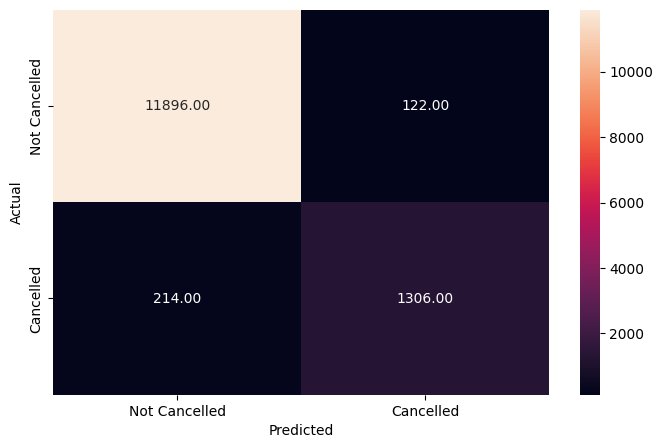

In [1001]:
metrics_score(y_test, y_pred)

In [1002]:
# On conserve en mémoire uniquement la probabilité de l'événement cible

y_train_predict_proba = xgb_model.predict_proba(x_train_encoded)[:,1]
print("\n Vecteur de probabilité de l'événement cible")
print(y_train_predict_proba)
y_test_predict_proba = xgb_model.predict_proba(x_test_encoded)[:,1]


 Vecteur de probabilité de l'événement cible
[2.6455916e-06 1.5666379e-06 2.2286740e-05 ... 4.7159656e-06 8.5251145e-08
 6.8233380e-06]


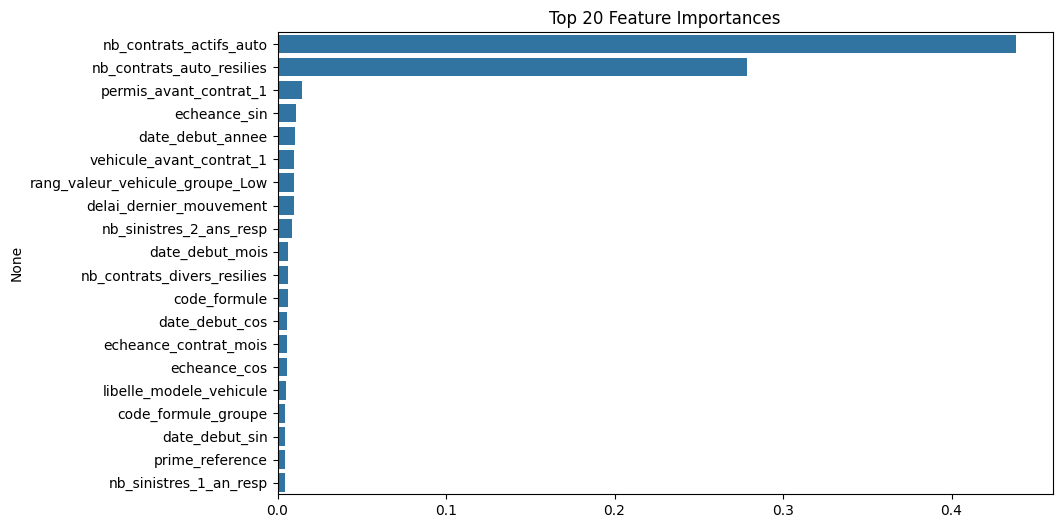

In [1003]:
importances = xgb_model.feature_importances_
features = x_train_encoded.columns
sorted_idx = np.argsort(importances)[::-1]

plt.figure(figsize=(10,6))
sns.barplot(x=importances[sorted_idx][:20], y=features[sorted_idx][:20])
plt.title("Top 20 Feature Importances")
plt.show()


🔝 1. nb_contrats_actifs_auto
Variable n°1, très logique : un client avec plusieurs contrats actifs peut être plus engagé, moins enclin à résilier.

Inversement, si cette variable vaut 1 ou 0, cela peut signaler une fragilité ou un client peu fidèle.

🔝 2. nb_contrats_auto_resilies
Indique probablement les résiliations passées du client, sur d’autres contrats.

Extrêmement pertinent pour prédire une résiliation future : c’est un signal fort de comportement répétitif ou instable.

🔝 3. permis_avant_contrat_1
Variable un peu moins intuitive.

Peut indiquer une nouveauté de conduite, ou à l’inverse une expérience de conduite hors réseau actuel.

Cela pourrait refléter un type de profil moins fidèle, ou "opportuniste".

🟨 Variables moyennement importantes:
date_debut_annee, echeance_contrat_mois, delai_dernier_mouvement :
Des indicateurs de temporalité qui peuvent signaler :

Une ancienneté courte → plus de risque de churn.

Une échéance proche → possible non-renouvellement.

Peu de mouvement récent → client désengagé.

🔽 Variables peu importantes:
code_formule, rang_valeur_vehicule, libelle_modele_vehicule, etc.
Jouent un rôle très mineur dans la prédiction du churn.

Cela signifie que :

Le type de voiture ou de tarif n’est pas un facteur déterminant,

Ou que cette information est déjà prise en compte indirectement via d’autres variables.

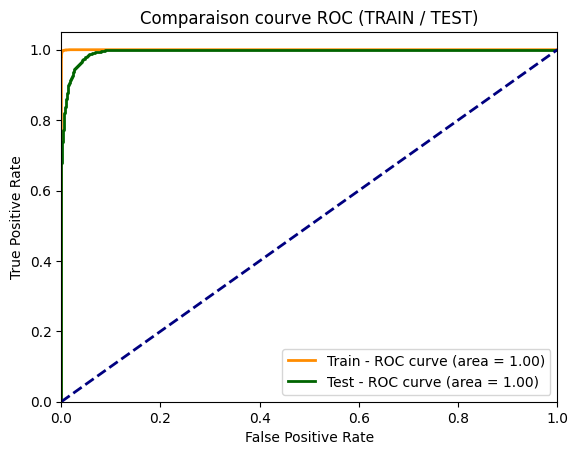

In [1004]:
# Creation des courbes ROC
from sklearn.metrics import roc_curve, auc
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_predict_proba)
roc_auc_train = auc(fpr_train, tpr_train)
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_predict_proba)
roc_auc_test = auc(fpr_test, tpr_test)

# Représentation graphique / courbe ROC
import matplotlib.pyplot as plt
plt.figure()
lw = 2
plt.plot(fpr_train, tpr_train, color='darkorange',
         lw=lw, label='Train - ROC curve (area = %0.2f)' % roc_auc_train)

plt.plot(fpr_test, tpr_test, color='darkgreen',
         lw=lw, label='Test - ROC curve (area = %0.2f)' % roc_auc_test)

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Comparaison courve ROC (TRAIN / TEST)')
plt.legend(loc="lower right")
plt.show()


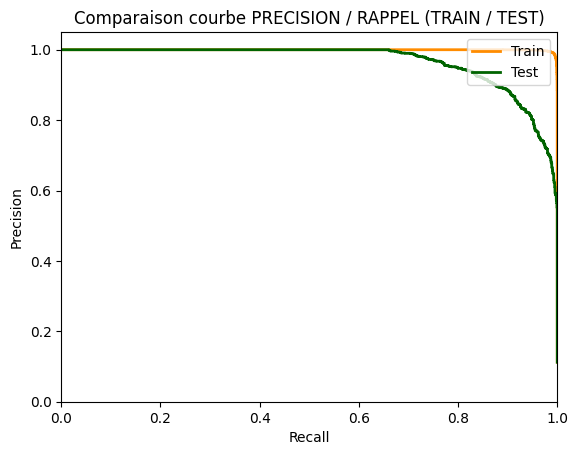

In [1005]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
precision_train, recall_train, thresholds_train = precision_recall_curve(y_train,
                                                                         y_train_predict_proba)
precision_test, recall_test, thresholds_test = precision_recall_curve(y_test, 
                                                                      y_test_predict_proba)
plt.figure()
lw = 2
plt.plot(recall_train,precision_train, color='darkorange',
         lw=lw, label='Train')

plt.plot(recall_test,precision_test, color='darkgreen',
         lw=lw, label='Test')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Comparaison courbe PRECISION / RAPPEL (TRAIN / TEST)')
plt.legend(loc="upper right")
plt.show()

Le modèle semble surapprendre. Pourtant nous avons retiré toutes les variebles qui nous sembleint trop magiques.

### 2.2 Model optimisé : 

Pour optimiser les résultats, le choix des paramètres est très important. Plusieurs approches :

    - Méthode aléatoire
    - Méthode grid Search
    - Méthode Optimisation Bayesienne 

In [ ]:
import random
from skopt import BayesSearchCV
from skopt.space import Real, Integer,Categorical
# Création du dictionnaire des indicateurs que nous souhaitons testés pour la méthode Random ou GridSearch
param_dict = {
    'criterion': ['gini', 'entropy'], # Le critère de split des arbres
    'splitter': ['best','random'],    # Est-ce que l'on teste un échantillon de variable (random) 
                                        #ou toutes les variables (best) à chaque neoud
    'max_depth': [3,4,10],  # Profondeur maximum de l'arbre
    'min_samples_split': [2,4], # # Nombre d'observations mimnimum pour créer un split
    'min_samples_leaf': [1,5,10],     # Nombre d'observations minimum dans une feuille
    'min_weight_fraction_leaf': [0,0.01], # Proportion minimum des observations dans une feuille
    'max_features': ['log2',"sqrt"]}

#Création  du dictionnaire de recherche pour la méthode d'optimisation bayesienne


xgb = XGBClassifier() 
# Définition des paramètres avec des lois de probabilités
param_dict_bayes = {
    'criterion': Categorical(['gini', 'entropy']), 
    'splitter': Categorical(['best','random']),
    'max_depth': Integer(3,30),
    'min_samples_split': Integer(2,50),
    'min_samples_leaf': Integer(1,20),
    'min_weight_fraction_leaf': Real(0,0.5, prior='uniform')}

# Grilles des paramètres

NB_ITER = 5 # Nombre d'itéations maximum pour le Random et l'optimisation Bayesienne 

#Tirage aléatoire d'une combinaison de paramètre

from sklearn.model_selection import cross_validate
# Définition d'une fonction 
def random_parameter(xgb,param_dict,n_iter,x_train_encoded,y_train,nb_cv) :
    res = pd.DataFrame()
    compt = 0
    num_iter = []
    auc=[]
    param = []
    while compt <n_iter :
        compt = compt +1
        params = {key: random.sample(value, 1)[0] for key, value in param_dict.items()}
        xgb.set_params(**params)
        scores = cross_validate(xgb, x_train_encoded, y_train, cv=5,
                        scoring = ['roc_auc'])
        num_iter.append(compt)
        param.append(params)
        auc.append(scores['test_roc_auc'].mean())
    
    res["Num_ITER"] = num_iter
    res["Param"] = param
    res["Auc"] = auc
    
    return res
  
 

from timeit import default_timer as timer
start = timer()  
Random_Res_Tree = random_parameter(XGBClassifier() ,param_dict,NB_ITER,x_train_encoded,y_train,5)
delais = timer()- start
print(" #### RECHERCHE ALEATOIRE #### ")
print(" \n Durée de recherche en seconde :")
print(delais)
Random_Res_Tree.sort_values('Auc', ascending = False, inplace = True)
Random_Res_Tree.head()
# Récupère les paramètres qui nous intéresse :
best_param_random_search = list(Random_Res_Tree["Param"])[0]
print("\n Paramètres recherche aléatoire : ")
print(best_param_random_search)

print("\n Résultats recherche aléatoire : " + str(Random_Res_Tree['Auc'].max()))


####  choix des paramètres : utilisation du  Grid Search


from sklearn.model_selection import GridSearchCV
 
start = timer()  
Grid_Search = GridSearchCV(XGBClassifier(),param_dict,scoring='roc_auc',cv=5)
Grid_Search.fit(x_train_encoded,y_train)
delais = timer()- start
print(" #### RECHERCHE GRID SEARCH #### ")
print(" \n Durée de recherche en minute :")
print(delais/60)
print("\n Paramètres grid search : ")
best_param_gid_search = Grid_Search.best_params_
print(best_param_gid_search)
best_score_grid_search = Grid_Search.best_score_
print("\n Résultats grid search  : " + str(best_score_grid_search))



opt = BayesSearchCV(xgb,param_dict_bayes , n_iter=NB_ITER,cv=5,scoring = 'roc_auc')
start = timer()  
opt.fit(x_train_encoded, y_train)
delais = timer()- start

print(" #### RECHERCHE OPTIMISATION #### ")
print(" \n Durée de recherche en seconde :")
print(delais)
print("\n Paramètres grid search : ")
best_param_opti_bayes =opt.best_params_
print(best_param_opti_bayes)
best_score_opti_bayes = opt.best_score_
print("\n Résultats grid search  : " + str(best_score_opti_bayes))

[13:31:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "criterion", "max_features", "min_samples_leaf", "min_samples_split", "min_weight_fraction_leaf", "splitter" } are not used.

[13:31:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "criterion", "max_features", "min_samples_leaf", "min_samples_split", "min_weight_fraction_leaf", "splitter" } are not used.

[13:31:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "criterion", "max_features", "min_samples_leaf", "min_samples_split", "min_weight_fraction_leaf", "splitter" } are not used.

[13:31:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "criterion", "max_features", "min_samples_leaf", "min_samples_split", "min_weight_fraction_leaf", "splitter" } are not used.

[13:31:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "criterion", "max_features", "min_samples_leaf

 #### RECHERCHE ALEATOIRE #### 
 
 Durée de recherche en seconde :
6.828224875003798

 Paramètres recherche aléatoire : 
{'criterion': 'entropy', 'splitter': 'random', 'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 5, 'min_weight_fraction_leaf': 0, 'max_features': 'log2'}

 Résultats recherche aléatoire : 0.9944457470112648


[13:31:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "criterion", "max_features", "min_samples_leaf", "min_samples_split", "min_weight_fraction_leaf", "splitter" } are not used.

[13:31:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "criterion", "max_features", "min_samples_leaf", "min_samples_split", "min_weight_fraction_leaf", "splitter" } are not used.

[13:31:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "criterion", "max_features", "min_samples_leaf", "min_samples_split", "min_weight_fraction_leaf", "splitter" } are not used.

[13:31:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "criterion", "max_features", "min_samples_leaf", "min_samples_split", "min_weight_fraction_leaf", "splitter" } are not used.

[13:31:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "criterion", "max_features", "min_samples_leaf

 #### RECHERCHE GRID SEARCH #### 
 
 Durée de recherche en minute :
7.283861385416822

 Paramètres grid search : 
{'criterion': 'gini', 'max_depth': 4, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0, 'splitter': 'best'}

 Résultats grid search  : 0.9944457470112648


[13:38:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "criterion", "min_samples_leaf", "min_samples_split", "min_weight_fraction_leaf", "splitter" } are not used.

[13:38:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "criterion", "min_samples_leaf", "min_samples_split", "min_weight_fraction_leaf", "splitter" } are not used.

[13:38:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "criterion", "min_samples_leaf", "min_samples_split", "min_weight_fraction_leaf", "splitter" } are not used.

[13:38:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "criterion", "min_samples_leaf", "min_samples_split", "min_weight_fraction_leaf", "splitter" } are not used.

[13:38:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "criterion", "min_samples_leaf", "min_samples_split", "min_weight_fraction_leaf", "splitter" } are not used.



 #### RECHERCHE OPTIMISATION #### 
 
 Durée de recherche en seconde :
15.419783375022234

 Paramètres grid search : 
OrderedDict({'criterion': 'entropy', 'max_depth': 13, 'min_samples_leaf': 2, 'min_samples_split': 9, 'min_weight_fraction_leaf': 0.2637280947282937, 'splitter': 'best'})

 Résultats grid search  : 0.9942028140118021


[13:42:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "criterion", "max_features", "min_samples_leaf", "min_samples_split", "min_weight_fraction_leaf", "splitter" } are not used.

[13:42:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "criterion", "max_features", "min_samples_leaf", "min_samples_split", "min_weight_fraction_leaf", "splitter" } are not used.

[13:42:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "criterion", "min_samples_leaf", "min_samples_split", "min_weight_fraction_leaf", "splitter" } are not used.



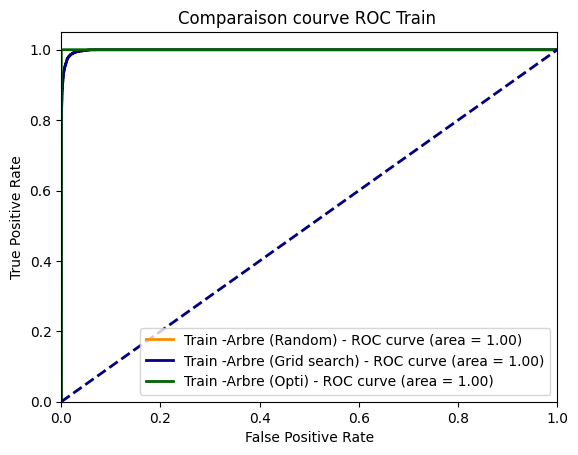

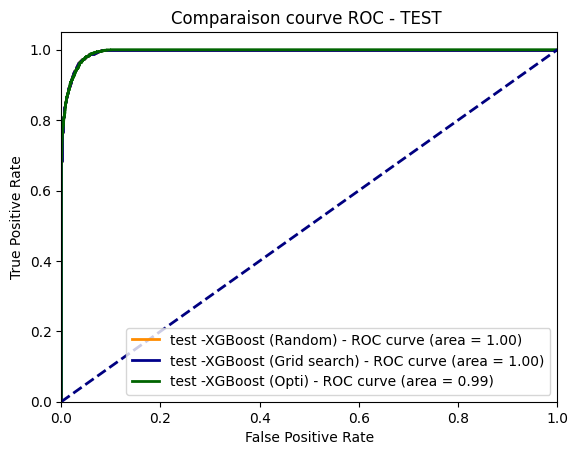

In [ ]:
# Comparaison des 3 modèles
import matplotlib.pyplot as plt
tree_random = XGBClassifier(**best_param_random_search)
tree_grid_search = XGBClassifier(**Grid_Search.best_params_)
tree_opti =  XGBClassifier(**opt.best_params_)

tree_random.fit(x_train_encoded,y_train)
fpr_train_random, tpr_train_random, thresholds_train_random = roc_curve(y_train, tree_random.predict_proba(x_train_encoded)[:,1])
roc_auc_train_random = auc(fpr_train_random, tpr_train_random)

tree_grid_search.fit(x_train_encoded,y_train)
fpr_train_grid_search, tpr_train_grid_search, thresholds_train_grid_search = roc_curve(y_train, tree_grid_search.predict_proba(x_train_encoded)[:,1])
roc_auc_train_grid_search = auc(fpr_train_grid_search, tpr_train_grid_search)

tree_opti.fit(x_train_encoded,y_train)
fpr_train_opti, tpr_train_opti, thresholds_train_opti = roc_curve(y_train, tree_opti.predict_proba(x_train_encoded)[:,1])
roc_auc_train_opti = auc(fpr_train_opti, tpr_train_opti)



plt.figure()
lw = 2
plt.plot(fpr_train_random, tpr_train_random, color='darkorange',
         lw=lw, label='Train -Arbre (Random) - ROC curve (area = %0.2f)' % roc_auc_train_random)

plt.plot(fpr_train_grid_search, tpr_train_grid_search, color='darkblue',
         lw=lw, label='Train -Arbre (Grid search) - ROC curve (area = %0.2f)' % roc_auc_train_grid_search)

plt.plot(fpr_train_opti, tpr_train_opti, color='darkgreen',
         lw=lw, label='Train -Arbre (Opti) - ROC curve (area = %0.2f)' % roc_auc_train_opti)

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Comparaison courve ROC Train ')
plt.legend(loc="lower right")
plt.show()


fpr_test_random, tpr_test_random, _ = roc_curve(y_test, tree_random.predict_proba(x_test_encoded)[:,1])
roc_auc_test_random = auc(fpr_test_random, tpr_test_random)

fpr_test_grid_search, tpr_test_grid_search, _ = roc_curve(y_test, tree_grid_search.predict_proba(x_test_encoded)[:,1])
roc_auc_test_grid_search = auc(fpr_test_grid_search, tpr_test_grid_search)

fpr_test_opti, tpr_test_opti, _ = roc_curve(y_test, tree_opti.predict_proba(x_test_encoded)[:,1])
roc_auc_test_opti = auc(fpr_test_opti, tpr_test_opti)


plt.figure()
lw = 2
plt.plot(fpr_test_random, tpr_test_random, color='darkorange',
         lw=lw, label='test -XGBoost (Random) - ROC curve (area = %0.2f)' % roc_auc_test_random)

plt.plot(fpr_test_grid_search, tpr_test_grid_search, color='darkblue',
         lw=lw, label='test -XGBoost (Grid search) - ROC curve (area = %0.2f)' % roc_auc_test_grid_search)

plt.plot(fpr_test_opti, tpr_test_opti, color='darkgreen',
         lw=lw, label='test -XGBoost (Opti) - ROC curve (area = %0.2f)' % roc_auc_test_opti)

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')


plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Comparaison courve ROC - TEST ')
plt.legend(loc="lower right")
plt.show()

fpr_test, tpr_test, _ = roc_curve(y_test, y_test_predict_proba)
roc_auc_test = auc(fpr_test, tpr_test)

Pas de réelle différence apres optimisation. 

Pour eviter le surapprentissage nous allons tester des modèles plus simple et interpretable tels que la regression logistique et le random forest.